Author: Vijul Shah<br/>
Contact E-mail: shahv@rhrk.uni-kl.de<br/>
Project: ML & DL methods on Earth Observation data and applications<br/>
Dataset Used: Nasa Marine Debris<br/>

Saving API Key from RadianMLHub Profile

In [1]:
import os
os.environ['MLHUB_API_KEY'] = '8d8dbdc600cc30921997e84958917fca835349a61e3ece54b671d7a5bc4e3693'

Importing Necessary Libraries

In [2]:
import json
import re
from glob import glob
import tarfile

from pathlib import Path
from radiant_mlhub import Dataset, Collection, client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asarray

import copy
import torch
from torch import nn, optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import requests
from PIL import Image
from io import BytesIO

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform_to_tensor = transforms.Compose([transforms.ToTensor()])
transform_pil_to_tensor = transforms.Compose([transforms.PILToTensor()])

### Fetching Dataset

In [4]:
datasetname = 'nasa_marine_debris'
dataset = Dataset.fetch(datasetname)

print('Source Imagery Collections\n--------------------------')
for collection in dataset.collections.source_imagery:
    print(collection.id)

print('')

print('Label Collections\n-----------------')
for collection in dataset.collections.labels:
    print(collection.id)

Source Imagery Collections
--------------------------
nasa_marine_debris_source

Label Collections
-----------------
nasa_marine_debris_labels


In [5]:
def print_summary(item, collection):
    print(f'Collection: {collection.id}')
    print(f'Item: {item["id"]}')
    print('Assets:')
    for asset_name, asset in item.get('assets', {}).items():
        print(f'- {asset_name}: {asset["href"]} {asset["type"]}')
    
    print('\n')

for collection in dataset.collections:
    item = next(client.list_collection_items(collection.id, limit=1))
    print_summary(item, collection)

Collection: nasa_marine_debris_source
Item: nasa_marine_debris_source_20190418_074358_0f3c_37604-25021-16
Assets:
- image_jpeg: https://api.radiant.earth/mlhub/v1/download/gAAAAABjXDvmEY_ih_8DQod98cR96JhXnlbMH4wirY6V-xX3qmVIIr4bjfgFBGmtMEXwrXE1kjCkflIFC_MFJJS-UX5Jdv8Rg8rLk1j6X88HxZ5Y_j-AiRSu0DK9-6fUXM4qSTzaYXQORSAivlXhsBSD8evdGNJs1m-WAojNeQ1V8ccN1R009cDtTPdNF2OYNofM9_0pWxMpbpmWMQ6vAroypYEgK2ucfUf9PGs0Nb1rJudV6U7WhNnZyNssLFwMa5c2atabhzjiUxwRxWrl0eriwjHgGIDUiRY_XfGLTI2ZMOo6EDF2ReNjv7sQD8m_NV418LnBJ3mM image/jpeg
- image_geotiff: https://api.radiant.earth/mlhub/v1/download/gAAAAABjXDvmGqgheqQlHvGWDLvNqzH-ADlhrIhBmGAU1--LB2AhilzcDtxsvnhPx-jPDi-2hDKq8qG3nexhnwDhtbLqTxxy0VbYK7VjDlJ-fH8X8M_igtJWMcUXGHBbgXNWRlKzgOmb4PPibbESDx_vHG5TSEfjOG1TQ8itCzu6lIMlY8pxGO81aAftJuCeY9MRZI2o9OpVhktjYdfhIqaIpEnilWjAjKY2vbFzucJYb6qmIA6O_mMUoHFsdHdT5skR-0uusSkMkTxubFFTCyH6kceYFx5S8pF4gnKAgM09Wn82X2KAJYY7UOPGF2av7gyxRstrZgOR image/tiff; application=geotiff


Collection: nasa_marine_debris_labels
Item: nasa_marine_

### Downloading dataset to local folder

In [6]:
# Use this to download to a data folder the current working directory in windows
download_dir = Path('./data').resolve()

# Use this to download the the typical Mac user Downloads folder
# download_dir = Path('~/Downloads').expanduser().resolve()

# Use this to download to the typical Linux /tmp directory
# download_dir = Path('/tmp')

In [7]:
# NOTE: Extracting the archives takes a while so this cell may take 5-10 minutes to complete
# archive_paths = dataset.download(output_dir=download_dir)
# for archive_path in archive_paths:
#     print(f'Extracting {archive_path}...')
#     with tarfile.open(archive_path) as tfile:
#         tfile.extractall(path=download_dir)
# print('Done')

### Loading Data into a Dataframe

In [8]:
train_source = 'nasa_marine_debris_source'
train_labels = 'nasa_marine_debris_labels'

Training Data

In [9]:
train_data = []
jpg_names = glob(str(download_dir / datasetname / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    labels_path = "./data/nasa_marine_debris/nasa_marine_debris_labels/" + jpg_path.parent.stem.replace('source','labels') +"/pixel_bounds.npy"
    
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[1:])
        
    # Load the labels data
    pixels_bound = np.load(labels_path).tolist()
    
    img = Image.open(jpg_path)
    img = transform_pil_to_tensor(img)

    for box in pixels_bound:
        train_data.append([
            image_id,
            img,
            box[4],
            box[0],
            box[1],
            box[2],
            box[3]
        ])

df = pd.DataFrame(
    np.array(train_data),
    columns=['img_id', 'image', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax']
).sort_values(by=['img_id']).reset_index(drop=True)

df.to_numpy()
df.head()

C:\Users\VIJUL\AppData\Local\Temp\ipykernel_15684\3017126005.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_data),


,img_id,image,class_id,xmin,ymin,xmax,ymax
0,074358_0f3c_37604-25021-16,"[[[tensor(199, dtype=torch.uint8), tensor(202,...",1,159,145,187,177
1,074358_0f3c_37604-25021-16,"[[[tensor(199, dtype=torch.uint8), tensor(202,...",1,42,16,74,48
2,075902_103e_39052-26411-16,"[[[tensor(38, dtype=torch.uint8), tensor(41, d...",1,117,71,147,96
3,075902_103e_39052-26411-16,"[[[tensor(38, dtype=torch.uint8), tensor(41, d...",1,121,56,140,78
4,075902_103e_39053-26412-16,"[[[tensor(40, dtype=torch.uint8), tensor(41, d...",1,128,0,163,15


### Visualizing the bounding boxe on debris

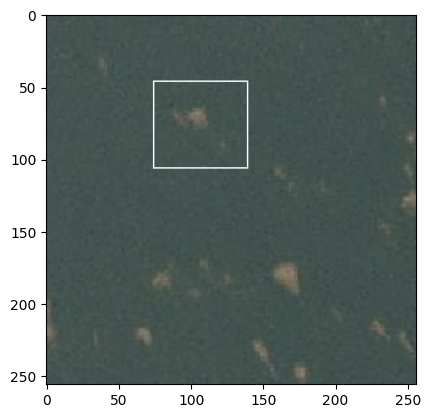

In [10]:
sample_data = df.iloc[np.random.randint(0,len(df))]
bbox = torch.tensor([sample_data["xmin"], sample_data["ymin"], sample_data["xmax"], sample_data["ymax"]], dtype=torch.float)
bbox = bbox.unsqueeze(0)
img = sample_data['image']
img = draw_bounding_boxes(img, bbox, width=1, colors=(255,255,255))
img = torchvision.transforms.ToPILImage()(img)
plt.imshow(img)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
bboxes = []
images = []
labels = []
for d in range(len(df)):
    bboxes.append([df.iloc[d]["xmin"], df.iloc[d]["ymin"], df.iloc[d]["xmax"], df.iloc[d]["ymax"]])
    images.append(df.iloc[d]["image"].numpy())
    labels.append(df.iloc[d]["class_id"])
images = np.array(images)
bboxes = np.array(bboxes)
labels = np.array(labels)
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes= train_test_split(images, labels, bboxes, test_size=0.2, random_state=42)

In [13]:
class CustomDataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.Tensor(train_images).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

In [14]:
class ValDataset(CustomDataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.Tensor(val_images).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [15]:
dataset = CustomDataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

In [16]:
batch_size = 32

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size, shuffle=True)

In [18]:
import torchvision.models as models
import torch.nn.functional as F

class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [19]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [20]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.float()
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [27]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    train_loss_array = []
    validation_accuracies = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        train_loss_array.append(train_loss)
        val_loss, val_acc = val_metrics(model, valdataloader, C)
        validation_accuracies.append(val_acc)
        print("Epoch:",i," -> train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    # plt.plot(train_loss_array)
    # plt.plot(validation_accuracies)
    return model

In [25]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Epoch: 0  -> train_loss 0.288 val_loss 0.295 val_acc 1.000
Epoch: 1  -> train_loss 0.287 val_loss 0.335 val_acc 0.994
Epoch: 2  -> train_loss 0.289 val_loss 0.295 val_acc 1.000


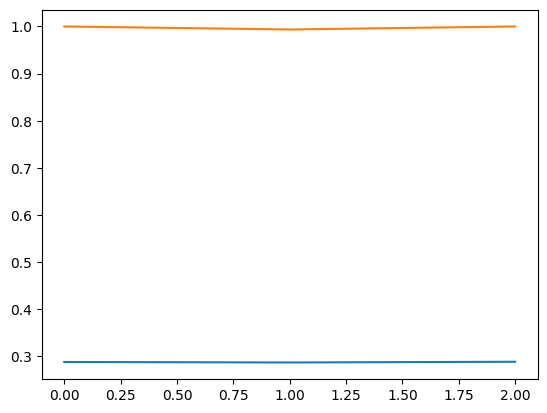

In [28]:
trained_model = train_epocs(model, optimizer, dataloader, valdataloader, epochs=3)

In [29]:
torch.save(trained_model, "Marine_Debris_Prediction_Model")

### Testing New Image On Trained Model

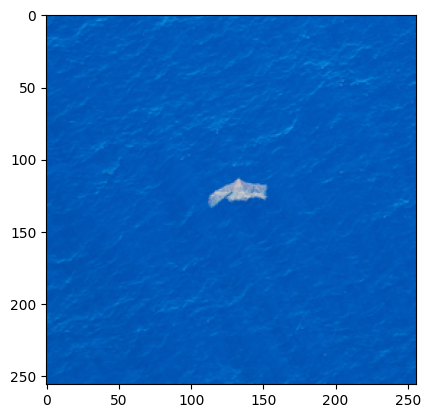

In [31]:
path = 'http://assets.iflscience.com/assets/articleNo/38282/iImg/40045/1475664999-toc-ae-29.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f)
    img = img.resize((256, 256))
x = (np.expand_dims(np.array(img), -1))/255.
plt.imshow(x.squeeze(-1))

In [52]:
path = 'http://assets.iflscience.com/assets/articleNo/38282/iImg/40045/1475664999-toc-ae-29.jpg'
r = requests.get(path)
test_image = None
predicted_result = None
with BytesIO(r.content) as f:
    img = Image.open(f)
    img = img.resize((256, 256))
    img = transform_pil_to_tensor(img)
    test_image = img
    img = img.float()
    img = torch.FloatTensor(img[None,])
    predicted_result = trained_model(img)
predicted_result

(tensor([[-2.7824,  7.0336, -2.8327, -2.3638]], grad_fn=<AddmmBackward0>),
 tensor([[ 81.8121,  87.2205, 162.5973, 171.9613]], grad_fn=<AddmmBackward0>))

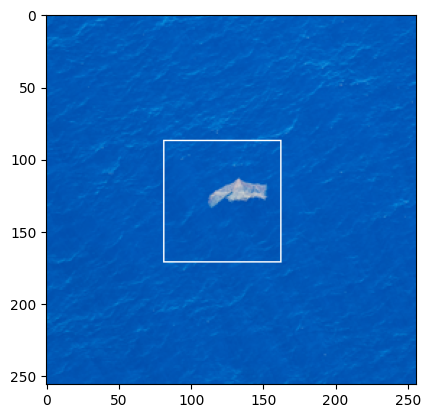

In [59]:
test_bbox = predicted_result[1][0]
test_bbox = test_bbox.unsqueeze(0)
test_bbox_img = draw_bounding_boxes(test_image, test_bbox, width=1, colors=(255,255,255))
test_bbox_img = torchvision.transforms.ToPILImage()(test_bbox_img)
plt.imshow(test_bbox_img)
plt.show()